In [751]:
from ppsim import species, Simulation, Specie
import numpy as np
from matplotlib import pyplot as plt

In [752]:
triplets = [[0, 1, 2], [3, 4, 5], [6, 7, 8],
            [0, 3, 6], [1, 4, 7], [2, 5, 8],
            [0, 4, 8], [2, 4, 6]] # winning combinations

In [753]:
def gen_string(prefix: str, n: int) -> str:
    to_return = ""
    for i in range(n):
        to_return += prefix + str(i) + " "
    return to_return[:-1]

In [754]:
def board(sim: Simulation) -> str:
    # return board state
    states = np.zeros((3,3), dtype=str)
    for i in range(9):
        if Specie(name=f'o{i}') in sim.config_dict.keys():
            states[i // 3, i % 3] = 'o'
        elif Specie(name=f'x{i}') in sim.config_dict.keys():
            states[i // 3, i % 3] = 'x'
        else:
            states[i // 3, i % 3] = '_'
    return states

In [755]:
def game_state(sim: Simulation) -> str:
    # return game state
    if Specie(name='win') in sim.config_dict.keys():
        return 'crn wins'
    elif Specie(name='draw') in sim.config_dict.keys():
        return 'draw'
    elif Specie(name='lose') in sim.config_dict.keys():
        return 'crn loses'
    else:
        return 'playing'

In [756]:
c, h, skip, w = species("c h skip w") # set up move markers (c, h, skip), waste molecule (w)
win, lose, draw = species("win lose draw") # set up game result markers
checkc, checkh = species("checkc checkh") # checking for stopping condition, resuming game
pre_checkc_fuel, pre_checkh_fuel, pre_comp_fuel = species("pre_checkc_fuel pre_checkh_fuel pre_comp_fuel") # fuel for both pre-check phases
checkc_fuel, checkh_fuel, comp_fuel = species("checkc_fuel checkh_fuel comp_fuel") # fuel for both check phases
continue_gameh, continue_gamec = species("continue_gameh continue_gamec") # continue game
# toggle clean up on, clean up off
cuon, cuoff = species("cuon cuoff")
# computing probabilities
p = species(gen_string("p", 9))
lp = species(gen_string("lp", 9))
hp = species(gen_string("hp", 9))
_p = species(gen_string("_p", 9))
vhp = species(gen_string("vhp", 9))
# option, try squares (crn playing a move)
opt = species(gen_string("opt", 9))
t = species(gen_string("t", 9))
# squares indicators - must be only one of these each
b = species(gen_string("b", 9))
x = species(gen_string("x", 9))
o = species(gen_string("o", 9))
# square interactors - can be many of these for use in check-phases, probability computation
b_temp_h = species(gen_string("b_temp_h", 9))
b_temp_c = species(gen_string("b_temp_c", 9))
b_temp_p = species(gen_string("b_temp_p", 9))
x_temp_h = species(gen_string("x_temp_h", 9))
x_temp_c = species(gen_string("x_temp_c", 9))
x_temp_p = species(gen_string("x_temp_p", 9))
o_temp_h = species(gen_string("o_temp_h", 9))
o_temp_c = species(gen_string("o_temp_c", 9))
o_temp_p = species(gen_string("o_temp_p", 9))
# intermediates for computation
filled_h, filled_c = species(gen_string("filled_h", 8)), species(gen_string("filled_c", 8))
inter_triplet_h, inter_triplet_c = species(gen_string("inter_triplet_h", 24)), species(gen_string("inter_triplet_c", 24))
inter_sum_h, inter_sum_c = species(gen_string("inter_sum_h", 8)), species(gen_string("inter_sum_c", 8))
continue_triplet_h, continue_triplet_c = species(gen_string("continue_triplet_h", 8)), species(gen_string("continue_triplet_c", 8))
# track move that was made
m = species(gen_string("m", 9))
# inject a move: human's turn, produces mh to make human move
inject = species(gen_string("i", 9))
mv = species(gen_string("mv", 9)) # checks if move is valid
mh = species(gen_string("mh", 9)) # makes move
mm = species(gen_string("mx", 9)) # move has been made

In [757]:
def add_checkphase(rules: list, o_temp: list[Specie], x_temp: list[Specie], b_temp: list[Specie],
                   inter_triplet: list[Specie], inter_sum: list[Specie],
                   continue_triplet: list[Specie], filled: list[Specie],
                   continue_game: Specie):
    # triplet reactions - checking phase
    for i, triplet in enumerate(triplets):
        # generate win if all three are O: o0 + o1 + o2 -> win
        rules.append(o_temp[triplet[0]] + o_temp[triplet[1]] >> inter_triplet[i] + w)
        rules.append(inter_triplet[i] + o_temp[triplet[2]] >> win + w)
        # generate lose if all three are X: x0 + x1 + x2 -> lose
        rules.append(x_temp[triplet[0]] + x_temp[triplet[1]] >> inter_triplet[i+8] + w)
        rules.append(inter_triplet[i+8] + x_temp[triplet[2]] >> lose + w)
        # generate filled[i] if all three are filled: x/o1 + x/o2 + x/o3 -> filled[i]
        rules.append(x_temp[triplet[0]] + o_temp[triplet[1]] >> inter_triplet[i+16] + w)
        rules.append(o_temp[triplet[0]] + x_temp[triplet[1]] >> inter_triplet[i+16] + w)
        rules.append(x_temp[triplet[0]] + x_temp[triplet[1]] >> inter_triplet[i+16] + w)
        rules.append(o_temp[triplet[0]] + o_temp[triplet[1]] >> inter_triplet[i+16] + w)
        rules.append(inter_triplet[i+16] + x_temp[triplet[2]] >> filled[i] + w)
        rules.append(inter_triplet[i+16] + o_temp[triplet[2]] >> filled[i] + w)
        # generate continue_triplet[i] if none of the above (this is the hard one)
        rules.append(b_temp[triplet[0]] >> continue_triplet[i])
        rules.append(b_temp[triplet[1]] >> continue_triplet[i])
        rules.append(b_temp[triplet[2]] >> continue_triplet[i]) # if any blanks, continue
        rules.append(x_temp[triplet[0]] + o_temp[triplet[1]] >> continue_triplet[i] + w) # xo_
        rules.append(o_temp[triplet[0]] + x_temp[triplet[1]] >> continue_triplet[i] + w) # ox_
        rules.append(x_temp[triplet[1]] + o_temp[triplet[2]] >> continue_triplet[i] + w) # _xo
        rules.append(o_temp[triplet[1]] + x_temp[triplet[2]] >> continue_triplet[i] + w) # _ox
        rules.append(x_temp[triplet[0]] + o_temp[triplet[2]] >> continue_triplet[i] + w) # x_o
        rules.append(o_temp[triplet[0]] + x_temp[triplet[2]] >> continue_triplet[i] + w) # o_x

        # clean up triplets
        for mol in [inter_triplet[i], inter_triplet[i+8], inter_triplet[i+16],
                    continue_triplet[i], inter_sum[i], filled[i]]:
            rules.append(mol + cuon >> cuon + w)

    # summing triplet results: draw
    rules.append(filled[0] + filled[1] >> inter_sum[0] + w)
    rules.append(inter_sum[0] + filled[2] >> draw + w)
    rules.append(filled[3] + filled[4] >> inter_sum[1] + w)
    rules.append(inter_sum[1] + filled[5] >> draw + w)

    # summing triplet results: continue only if every triplet continues
    rules.append(continue_triplet[0] + continue_triplet[1] >> inter_sum[2] + w)
    rules.append(continue_triplet[2] + continue_triplet[3] >> inter_sum[3] + w)
    rules.append(continue_triplet[4] + continue_triplet[5] >> inter_sum[4] + w)
    rules.append(continue_triplet[6] + continue_triplet[7] >> inter_sum[5] + w) # level one
    rules.append(inter_sum[2] + inter_sum[3] >> inter_sum[6] + w)
    rules.append(inter_sum[4] + inter_sum[5] >> inter_sum[7] + w) # level two
    rules.append(inter_sum[6] + inter_sum[7] >> continue_game + w) # level three


In [798]:
def add_probability(rules: list, o_temp: list[Specie], x_temp: list[Specie], b_temp: list[Specie],
                    hp: list[Specie], p: list[Specie], lp: list[Specie], _p: list[Specie], w: Specie):
    # if middle square is blank, hp
    rules.append(b_temp[4] + w >> hp[4] + w)
    # for each triplet[i], decide a probability based on the state of the other two squares.
    for i, triplet in enumerate(triplets):
        # for each square in the triplet
        for j in range(3):
            # if other two are blank, p
            rules.append(b_temp[triplet[(j+1)%3]] + b_temp[triplet[(j+2)%3]] >> lp[triplet[j]] + w)
            # if other two are X, hp
            rules.append(x_temp[triplet[(j+1)%3]] + x_temp[triplet[(j+2)%3]] >> hp[triplet[j]] + w)
            # if other two are O, vhp
            rules.append(o_temp[triplet[(j+1)%3]] + o_temp[triplet[(j+2)%3]] >> vhp[triplet[j]] + w)
            # if one is O, one is X, lp
            rules.append(x_temp[triplet[(j+1)%3]] + o_temp[triplet[(j+2)%3]] >> _p[triplet[j]] + w)
            rules.append(o_temp[triplet[(j+1)%3]] + x_temp[triplet[(j+2)%3]] >> _p[triplet[j]] + w)
            # if one blank, one X, p
            rules.append(b_temp[triplet[(j+1)%3]] + x_temp[triplet[(j+2)%3]] >> lp[triplet[j]] + w)
            rules.append(x_temp[triplet[(j+1)%3]] + b_temp[triplet[(j+2)%3]] >> lp[triplet[j]] + w)
            # if one blank, one O, p
            rules.append(b_temp[triplet[(j+1)%3]] + o_temp[triplet[(j+2)%3]] >> lp[triplet[j]] + w)
            rules.append(o_temp[triplet[(j+1)%3]] + b_temp[triplet[(j+2)%3]] >> lp[triplet[j]] + w)


In [767]:
rules = []
# square molecule reactions
for i in range(9):
    # increased probability of hp moves, decreased probability of lp moves, no probability of _p moves
    rules.append(_p[i] + p[i] >> w + w)
    rules.append(lp[i] + lp[i] >> p[i] + w)
    rules.append(p[i] + p[i] >> hp[i] + w)
    rules.append(hp[i] + hp[i] >> vhp[i] + w)
    # rules.append(hp[i] + w >> hp[i] + p[i])

    # verification: p[i] + c + b[i] -> c + b[i] + t[i]
    rules.append(vhp[i] + c >> c + opt[i])
    # rules.append(p[i] + c >> c + opt[i])
    rules.append(opt[i] + b[i] >> t[i] + b[i])

    # make_move: requires a blank square and the move marker -> fills square and records move
    rules.append(t[i] + c >> o[i] + m[i])
    # move recorded -> decompose blank, generate human's turn
    rules.append(m[i] + b[i] >> w + checkc)

    # if human's turn, do the same thing, generate checking phase
    rules.append(inject[i] + b[i] >> mv[i] + b[i]) # move is valid
    rules.append(mv[i] + h >> mh[i] + h) # move is valid and human's turn
    rules.append(mh[i] + b[i] >> mm[i] + x[i]) # make move
    rules.append(mm[i] + h >> w + checkh) # end human's turn, move to checking phase
    rules.append(skip + h >> w + checkh) # skip human's turn, move to checking phase

    # clean up step
    for mol in [mh, mm, mv, lp, vhp, hp, _p, p, opt, t,
                b_temp_h, b_temp_c, b_temp_p,
                x_temp_h, x_temp_c, x_temp_p,
                o_temp_h, o_temp_c, o_temp_p]:
        rules.append(cuon + mol[i] >> cuon + w)
    
    # generate temporaries - for checking but also all the time
    rules.append(checkc_fuel + x[i] >> x[i] + x_temp_c[i])
    rules.append(checkh_fuel + x[i] >> x[i] + x_temp_h[i])
    rules.append(comp_fuel + x[i] >> x[i] + x_temp_p[i])
    rules.append(checkc_fuel + o[i] >> o[i] + o_temp_c[i])
    rules.append(checkh_fuel + o[i] >> o[i] + o_temp_h[i])
    rules.append(comp_fuel + o[i] >> o[i] + o_temp_p[i])
    rules.append(checkc_fuel + b[i] >> b[i] + b_temp_c[i])
    rules.append(checkh_fuel + b[i] >> b[i] + b_temp_h[i])
    rules.append(comp_fuel + b[i] >> b[i] + b_temp_p[i])

# control molecule clean up
for mol in [checkc_fuel, checkh_fuel, comp_fuel, continue_gameh, continue_gamec]:
    rules.append(cuon + mol >> cuon + w)

# regenerating fuel -- should regenerate fuel with even probabilities
rules.append(cuon + w >> cuon + pre_checkc_fuel)
rules.append(cuon + w >> cuon + pre_checkh_fuel)
rules.append(cuon + w >> cuon + pre_comp_fuel)

# phase one: clean up off
rules.append(cuoff + cuon >> h + w) # toggle off clean up
# phase two: human plays move (h)
# phase three: checking human move (checkh)
rules.append(checkh + pre_checkh_fuel >> checkh + checkh_fuel) # create checkh_fuel for human checking
rules.append(checkh + continue_gameh >> c + w) # toggle off checking phase
# phase four: computer plays move (c)
rules.append(c + pre_comp_fuel >> c + comp_fuel) # create comp_fuel for crn move
# phase five: checking computer move (checkc)
rules.append(checkc + pre_checkc_fuel >> checkc + checkc_fuel) # create checkc_fuel for crn checking
rules.append(checkc + continue_gamec >> w + cuon) # toggle off checking phase, move to clean up

# add checking phase
add_checkphase(rules, o_temp_h, x_temp_h, b_temp_h,
               inter_triplet_h, inter_sum_h,
               continue_triplet_h, filled_h,
               continue_gameh)
add_checkphase(rules, o_temp_c, x_temp_c, b_temp_c,
               inter_triplet_c, inter_sum_c,
               continue_triplet_c, filled_c,
               continue_gamec)
# win/loss should override draw
rules.append(draw + win >> win + w)
rules.append(draw + lose >> lose + w)

# add probability computation
add_probability(rules, o_temp_p, x_temp_p, b_temp_p,
                hp, p, lp, _p, w)

In [760]:
def init_config():
    init_config = {}
    init_config[w] = 10 # surplus waste - I think this actually ends up affecting the probabilities
    init_config[h] = 1 # human's move
    init_config[pre_comp_fuel] = 200 # fuel for crn move
    init_config[pre_checkc_fuel] = 200 # fuel for crn checking
    init_config[pre_checkh_fuel] = 200 # fuel for human checking
    for i in range(9):
        init_config[b[i]] = 1 # all squares set to blank
    return init_config

In [761]:
# -2 for cuoff, 0 through 8 for corresponding move, -1 to inject skip
def injection(n: int, config: dict) -> dict:
    if n == -2:
        config[cuoff] = 1
    elif n == -1:
        config[skip] = 1
        config[w] = 10
    else:
        config[inject[n]] = 1
        config[w] = 10
    return config

In [762]:
def play_turn(n: int, config: dict) -> Simulation:
    sim = Simulation(injection(-2, config), rules) # clean up off
    sim.run()
    sim = Simulation(injection(n, sim.config_dict), rules) # inject human move
    sim.run()
    print(board(sim))
    print(game_state(sim))
    return sim
# n indicates move, -1 if computer should go first
def start_game(n: int, config: dict) -> Simulation:
    sim = Simulation(injection(n, config), rules) # inject human move or skip
    sim.run()
    print(board(sim))
    print(game_state(sim))
    return sim

In [802]:
# first move: -1 to let crn go first,
# 0-8 to make a move
sim = start_game(4, init_config())

[['_' '_' '_']
 ['_' 'x' '_']
 ['o' '_' '_']]
playing


In [803]:
# next moves: 0-8 to make a move
sim = play_turn(1, sim.config_dict)

[['_' 'x' '_']
 ['_' 'x' '_']
 ['o' '_' 'o']]
playing


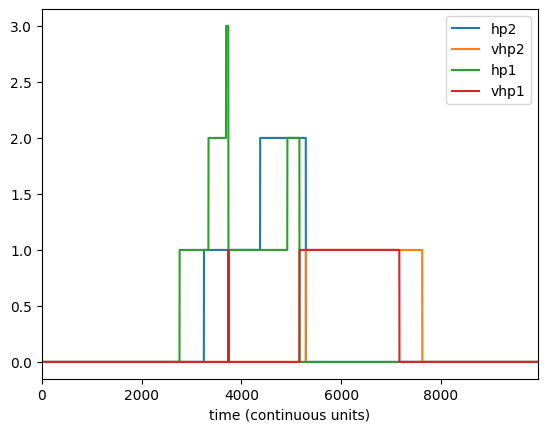

In [797]:
sim.history[['hp2','vhp2','hp1','vhp1']].plot()
plt.xlim(0, sim.times[-1])
plt.show()

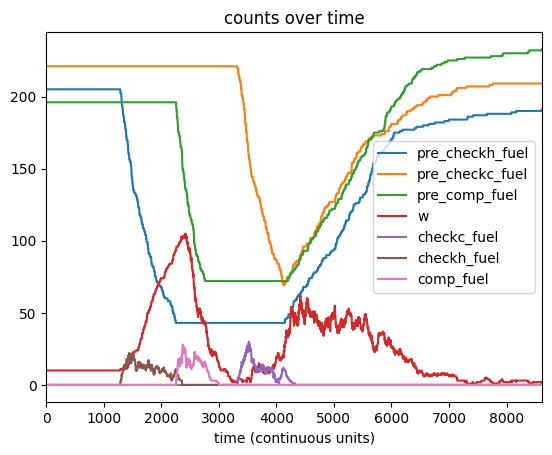

In [683]:
# plot results
sim.history[['pre_checkh_fuel','pre_checkc_fuel', 'pre_comp_fuel', 'w', 'checkc_fuel', 'checkh_fuel', 'comp_fuel']].plot()
# sim.history[['cuoff','h','checkh','c','m3','checkc','cuon']].plot()
plt.title("counts over time")
plt.xlim(0, sim.times[-1])
plt.show()

In [684]:
print(sim.config_dict)

{Specie(name='b6'): 1, Specie(name='b7'): 1, Specie(name='b8'): 1, Specie(name='cuon'): 1, Specie(name='o0'): 1, Specie(name='o2'): 1, Specie(name='o5'): 1, Specie(name='pre_checkc_fuel'): 209, Specie(name='pre_checkh_fuel'): 191, Specie(name='pre_comp_fuel'): 233, Specie(name='x1'): 1, Specie(name='x3'): 1, Specie(name='x4'): 1}
